In [1]:
import json
from pprint import pprint
from pathlib import Path
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.stats import bootstrap, norm

from tqdm import tqdm

from gsfanalysis.pandas_import import uproot_to_pandas
from gsfanalysis.core_tail_utils import rms

In [2]:
plt.rcParams.update({'font.size': 14})

In [51]:
def compute_stat_values(summary_df, key, stat, max_samples=None):
    stat_values = []

    for event_nr in range(max(summary_df["event_nr"])+1):
        df = summary_df[ summary_df["event_nr"] == event_nr ][:max_samples]
        stat_values.append(stat(df[key]))
        
    return stat_values

In [4]:
def plot(dist, sample_mean, standard_error, fig_ax = None, confidence_interval=None, confidence_level=None):
    x = np.linspace(sample_mean + 4*standard_error, sample_mean - 4*standard_error)
    pdf = norm.pdf(x, loc=sample_mean, scale=standard_error)

    fig, ax = fig_ax if fig_ax is not None else plt.subplots()
    ax.hist(dist, bins=25, density=True)
    ax.plot(x, pdf, label="µ={:.2f}, σ={:.4f}".format(sample_mean, standard_error), lw=5)
    ax.set_ylabel('pdf')
    
    ymax = ax.get_ylim()[1]

    ax.vlines([sample_mean], ymin=0, ymax=ymax, color="tab:orange", lw=3, label="mean {:.3f}".format(sample_mean))
    ax.vlines([sample_mean + standard_error, sample_mean - standard_error], ymin=0, ymax=ymax, color="tab:orange", ls="--", label="standard error {:.3f}".format(standard_error))
    
    if not (confidence_interval is None or confidence_level is None):
        ax.vlines(confidence_interval, ymin=0, ymax=ymax, color="tab:orange", ls=":", label="confidence interval {:.1%}".format(confidence_level))
        
    ax.set_ylim(0, ax.get_ylim()[1]*1.3)

    ax.legend()
    return fig, ax

In [32]:
def plot_for_stat(summary_df, stat, key, fig_ax=None):
    stat_values = compute_stat_values(summary_df, key, stat)
    fig, ax = plot(stat_values, np.mean(stat_values), np.std(stat_values), fig_ax=fig_ax)
    
    ax.set_title("sampling distribution {} {}".format(key, stat.__name__))
    ax.set_xlabel(stat.__name__)
    return fig, ax

In [33]:
input_dir_long = Path("../output/odd_n500_particles500/")

summary_long = uproot_to_pandas(uproot.open(str(input_dir_long / "root/tracksummary_gsf.root:tracksummary")))
len(summary_long)

248623

In [34]:
np.mean(summary_long["res_eQOP_fit"])

-0.011789656

In [35]:
rms(summary_long["res_eQOP_fit"])

0.18876408

In [36]:
np.mean(summary_long["pull_eQOP_fit"])

-0.28272396

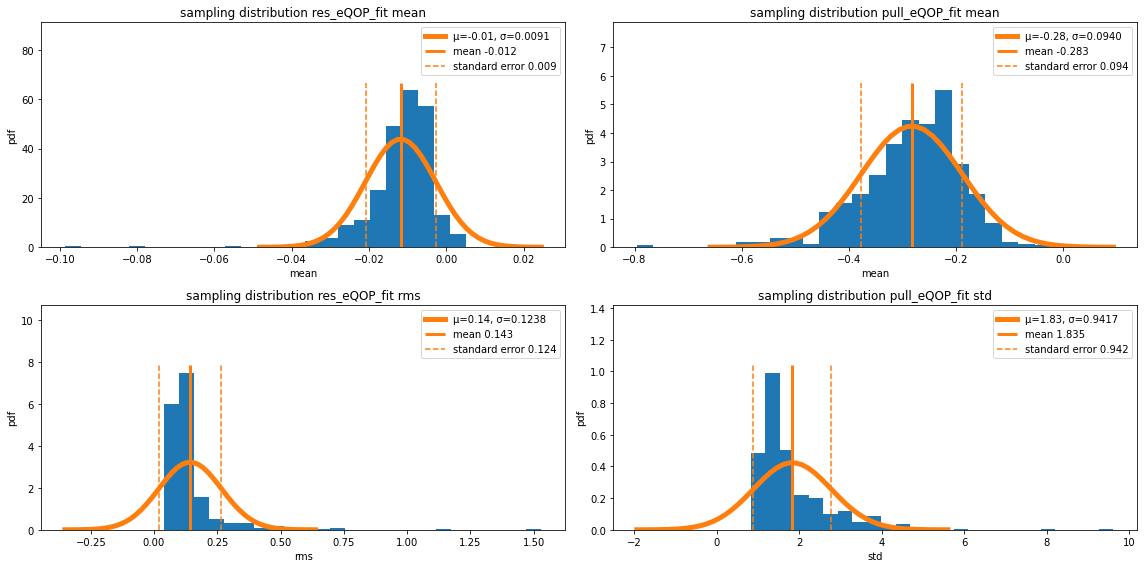

In [37]:
fig, ax = plt.subplots(2,2,figsize=(16,8))

plot_for_stat(summary_long, np.mean, "res_eQOP_fit", fig_ax=(fig, ax[0,0]))
plot_for_stat(summary_long, rms, "res_eQOP_fit", fig_ax=(fig, ax[1,0]))
plot_for_stat(summary_long, np.mean, "pull_eQOP_fit", fig_ax=(fig, ax[0,1]))
plot_for_stat(summary_long, np.std, "pull_eQOP_fit", fig_ax=(fig, ax[1,1]))

fig.tight_layout()

In [52]:
def go_through_events(input_df, stat, key):
    summary_df = input_df[ input_df["nOutliers"] == 0 ]
    
    min_event_size = min(input_df.groupby("event_nr").size())
    
    n_events = max(summary_df["event_nr"])+1
    #events = np.arange(1,n_events)
    events = np.unique(np.logspace(np.log10(1),np.log10(n_events)).astype(int))
    
    stat_values = []
    stat_errors = []
    
    sample_means = []
    sample_sems = []


    for max_event_nr in tqdm(events):
        event_range_df = summary_df[ summary_df["event_nr"] <= max_event_nr ]
        stat_dist = compute_stat_values(event_range_df, key, stat, min_event_size)

        stat_values.append(np.mean(stat_dist))
        stat_errors.append(np.std(stat_dist))
        
        sample_means.append(np.mean(event_range_df[key]))
        sample_sems.append(np.std(event_range_df[key]) / np.sqrt(len(event_range_df)))
    
    stat_values = np.array(stat_values)
    stat_errors = np.array(stat_errors)
    
    sample_means = np.array(sample_means)
    sample_sems = np.array(sample_sems)

    fig, ax = plt.subplots(1,2, figsize=(20,9))

    ax[0].plot(events, stat_values, label="mean of sampling dist for '{}'".format(stat.__name__), lw=4)
    ax[0].fill_between(events, stat_values-stat_errors, stat_values+stat_errors, alpha=0.3)
    if stat.__name__ == 'mean':
        ax[0].plot(events, sample_means, label="sample means", lw=2)
        ax[0].fill_between(events, sample_means-sample_sems, sample_means+sample_sems, alpha=0.3)
    ax[0].hlines([stat(summary_df[key])], xmin=1, xmax=events[-1], lw=2, label="{} of whole sample".format(stat.__name__, key), color='black', zorder=-10)
    ax[0].legend()

    ax[1].plot(events, stat_errors, label="std of sampling dist for '{}'".format(stat.__name__), lw=4)
    if stat.__name__ == 'mean':
        ax[1].plot(events, sample_sems, label="stdandard error of mean".format(stat.__name__), lw=4)
    ax[1].legend()

    for a in ax:
        a.set_xlabel("events included")
        a.set_xscale('log')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.60it/s]


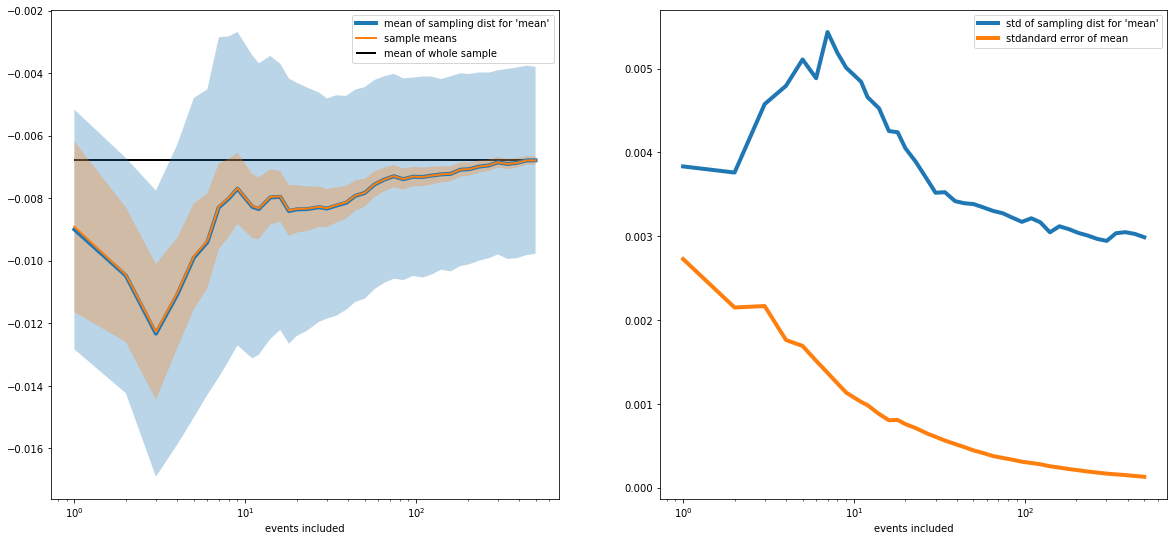

In [53]:
go_through_events(summary_long, np.mean, "res_eQOP_fit")

In [13]:
res = bootstrap((summary_long[ summary_long["event_nr"] < 10 ]["res_eQOP_fit"],), np.mean)
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.013798694021275967, high=-0.00507844066665216), bootstrap_distribution=array([-0.008885  , -0.00761159, -0.00908627, ..., -0.00697502,
       -0.00761199, -0.00836297], dtype=float32), standard_error=0.0021016488)

In [14]:
np.std(summary_long[ summary_long["event_nr"] < 10 ]["res_eQOP_fit"]) / np.sqrt(len(summary_long))

0.00029769628565488664

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:47<00:00, 10.59it/s]


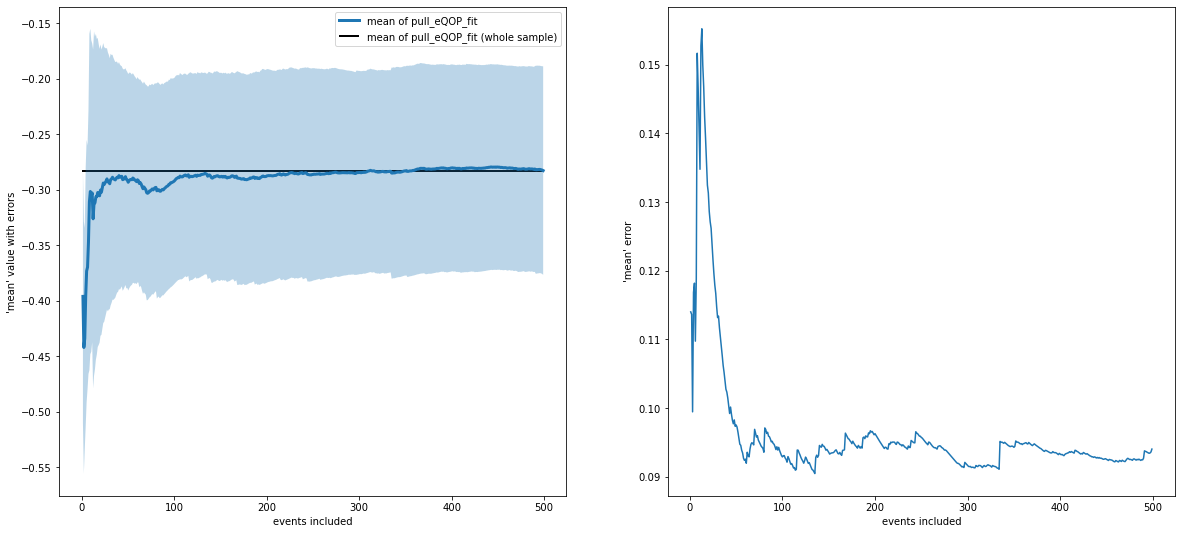

In [15]:
go_through_events(summary_long, np.mean, "pull_eQOP_fit")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:45<00:00, 11.02it/s]


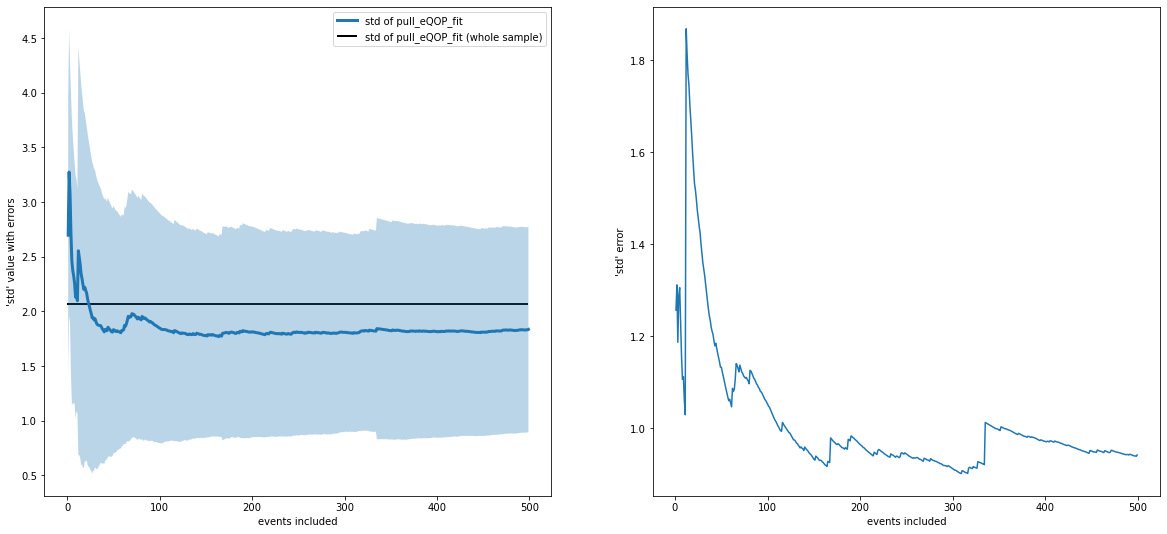

In [16]:
go_through_events(summary_long, np.std, "pull_eQOP_fit")